In [1]:
!pip install tensorflow keras matplotlib scikit-learn opencv-python


In [3]:
import os

data_dir = "/kaggle/input/plantdisease/plantvillage"

print(os.listdir(data_dir))


['PlantVillage']


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model


2025-09-11 13:30:31.352682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757597431.549508      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757597431.599994      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Define the source and destination directories
source_dir = '/kaggle/input/plantdisease/PlantVillage'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'testing')

# Create the directories
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Get all the classes (subdirectories)
classes = os.listdir(source_dir)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split the data
for cls in classes:
    class_path = os.path.join(source_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]

    # First split: 80% training, 20% temp
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)

    # Second split: 50% validation, 50% test (of the remaining 20%)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy files to new directories
    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, cls))
    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, cls))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, cls))

In [9]:

# Load the training set
training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42
)

# Load the validation set
validation_set = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False, # No need to shuffle validation data
    seed=42
)

# Load the test set
test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False, # No need to shuffle test data
    seed=42
)

Found 16504 files belonging to 15 classes.
Found 2064 files belonging to 15 classes.
Found 2070 files belonging to 15 classes.


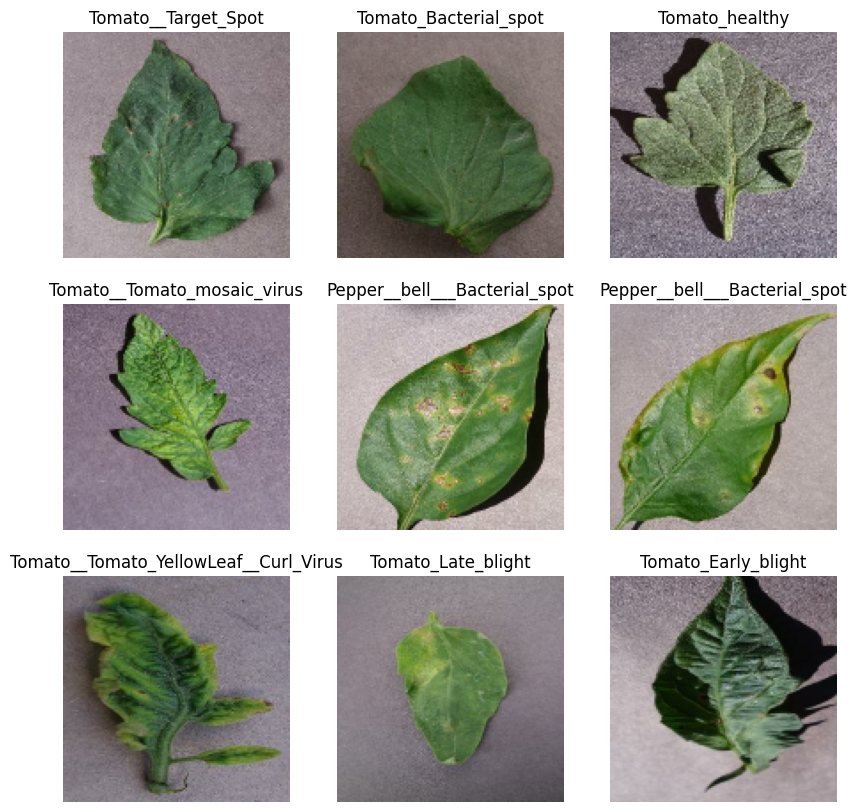

In [10]:

# Take one batch from training set
class_names = training_set.class_names

#to add
with open('class_names.pkl', 'wb') as file:
    pickle.dump(class_names, file)

print("Class names saved successfully as class_names.pkl")

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):   # take 1 batch
    for i in range(9):  # show first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


In [11]:
# Load the pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(15, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 40,373,135 (154.01 MB)

 Trainable params: 16,785,423 (64.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
for images, labels in training_set.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 128, 128, 3)
Labels shape: (32, 15)


In [14]:
training_history = model.fit(x=training_set,validation_data=validation_set,epochs=10)

Epoch 1/10


I0000 00:00:1757597689.811906     108 service.cc:148] XLA service 0x7ebdd8004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757597689.812803     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757597691.343693     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/516 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.1654 - loss: 21.1588 

I0000 00:00:1757597694.917997     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.6730 - loss: 3.8628 - val_accuracy: 0.8692 - val_loss: 0.3938
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8928 - loss: 0.3206 - val_accuracy: 0.9109 - val_loss: 0.2793
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9296 - loss: 0.2169 - val_accuracy: 0.9259 - val_loss: 0.2434
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9477 - loss: 0.1583 - val_accuracy: 0.9157 - val_loss: 0.3094
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9447 - loss: 0.1852 - val_accuracy: 0.9191 - val_loss: 0.3089
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9445 - loss: 0.1744 - val_accuracy: 0.9360 - val_loss: 0.2772
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9605 - loss: 0.1347 - val_accuracy: 0.9331 - val_loss: 0.2693
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9647 - loss: 0.1168 - val_accurac

In [96]:
# Assuming you have trained the 'model' you defined
model.save('plant_disease_model.keras')
print("Model saved successfully!")

Model saved successfully!


In [1]:
history_dict = training_history.history

# Save the dictionary to a file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

print("Training history saved successfully as training_history.pkl")

NameError: name 'training_history' is not defined

In [99]:
training_history.history #Return Dictionary of history

{'accuracy': [0.45401114225387573,
  0.7363669276237488,
  0.8229520320892334,
  0.8738487362861633,
  0.9079617261886597,
  0.9235336780548096,
  0.9370455741882324,
  0.9533446431159973,
  0.9606156349182129,
  0.96467524766922],
 'loss': [1.6873079538345337,
  0.7994372248649597,
  0.5295006036758423,
  0.3747158944606781,
  0.2822401821613312,
  0.22425724565982819,
  0.18337085843086243,
  0.13906951248645782,
  0.12239614874124527,
  0.10640691220760345],
 'val_accuracy': [0.6729651093482971,
  0.8299418687820435,
  0.8662790656089783,
  0.8914728760719299,
  0.895348846912384,
  0.9210271239280701,
  0.9186046719551086,
  0.9215116500854492,
  0.9326550364494324,
  0.9433139562606812],
 'val_loss': [0.9302657246589661,
  0.49467170238494873,
  0.39803624153137207,
  0.3289213478565216,
  0.31174734234809875,
  0.2261117398738861,
  0.24490396678447723,
  0.2661442160606384,
  0.23148448765277863,
  0.17343932390213013]}

In [100]:
loss, acc = model.evaluate(validation_set)
print(f"Validation Accuracy: {acc*100:.2f}%")


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9401 - loss: 0.1871
Validation Accuracy: 94.33%


In [101]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


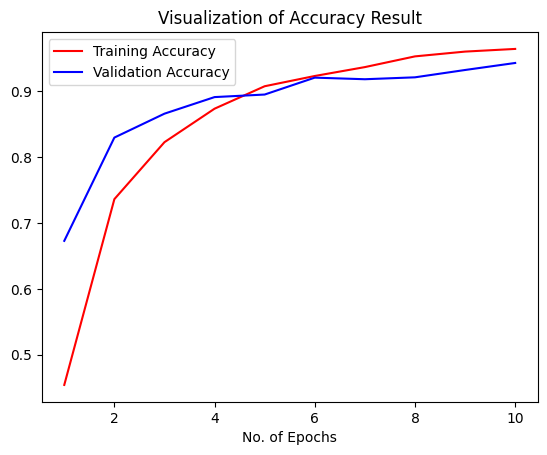

In [102]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [104]:
class_name = validation_set.class_names

In [110]:
test_dir = '/kaggle/working/split_data/testing'
image_size = (128, 128)
batch_size = 32 # Use the same batch size as training

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2070 files belonging to 15 classes.


In [111]:
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

2070/2070 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [112]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [113]:
Y_true

<tf.Tensor: shape=(2070,), dtype=int64, numpy=array([ 0,  0,  0, ..., 14, 14, 14])>

In [114]:
predicted_categories

<tf.Tensor: shape=(2070,), dtype=int64, numpy=array([ 0,  0,  0, ..., 14, 14, 14])>

In [115]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [116]:
# Precision Recall Fscore
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.88      0.92       100
                     Pepper__bell___healthy       0.93      0.99      0.96       148
                      Potato___Early_blight       0.84      0.98      0.90       100
                       Potato___Late_blight       0.95      0.78      0.86       100
                           Potato___healthy       0.87      0.81      0.84        16
                      Tomato_Bacterial_spot       0.95      0.99      0.97       213
                        Tomato_Early_blight       0.92      0.89      0.90       100
                         Tomato_Late_blight       0.91      0.93      0.92       191
                           Tomato_Leaf_Mold       0.96      0.95      0.95        96
                  Tomato_Septoria_leaf_spot       0.94      0.93      0.93       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.95      0.94

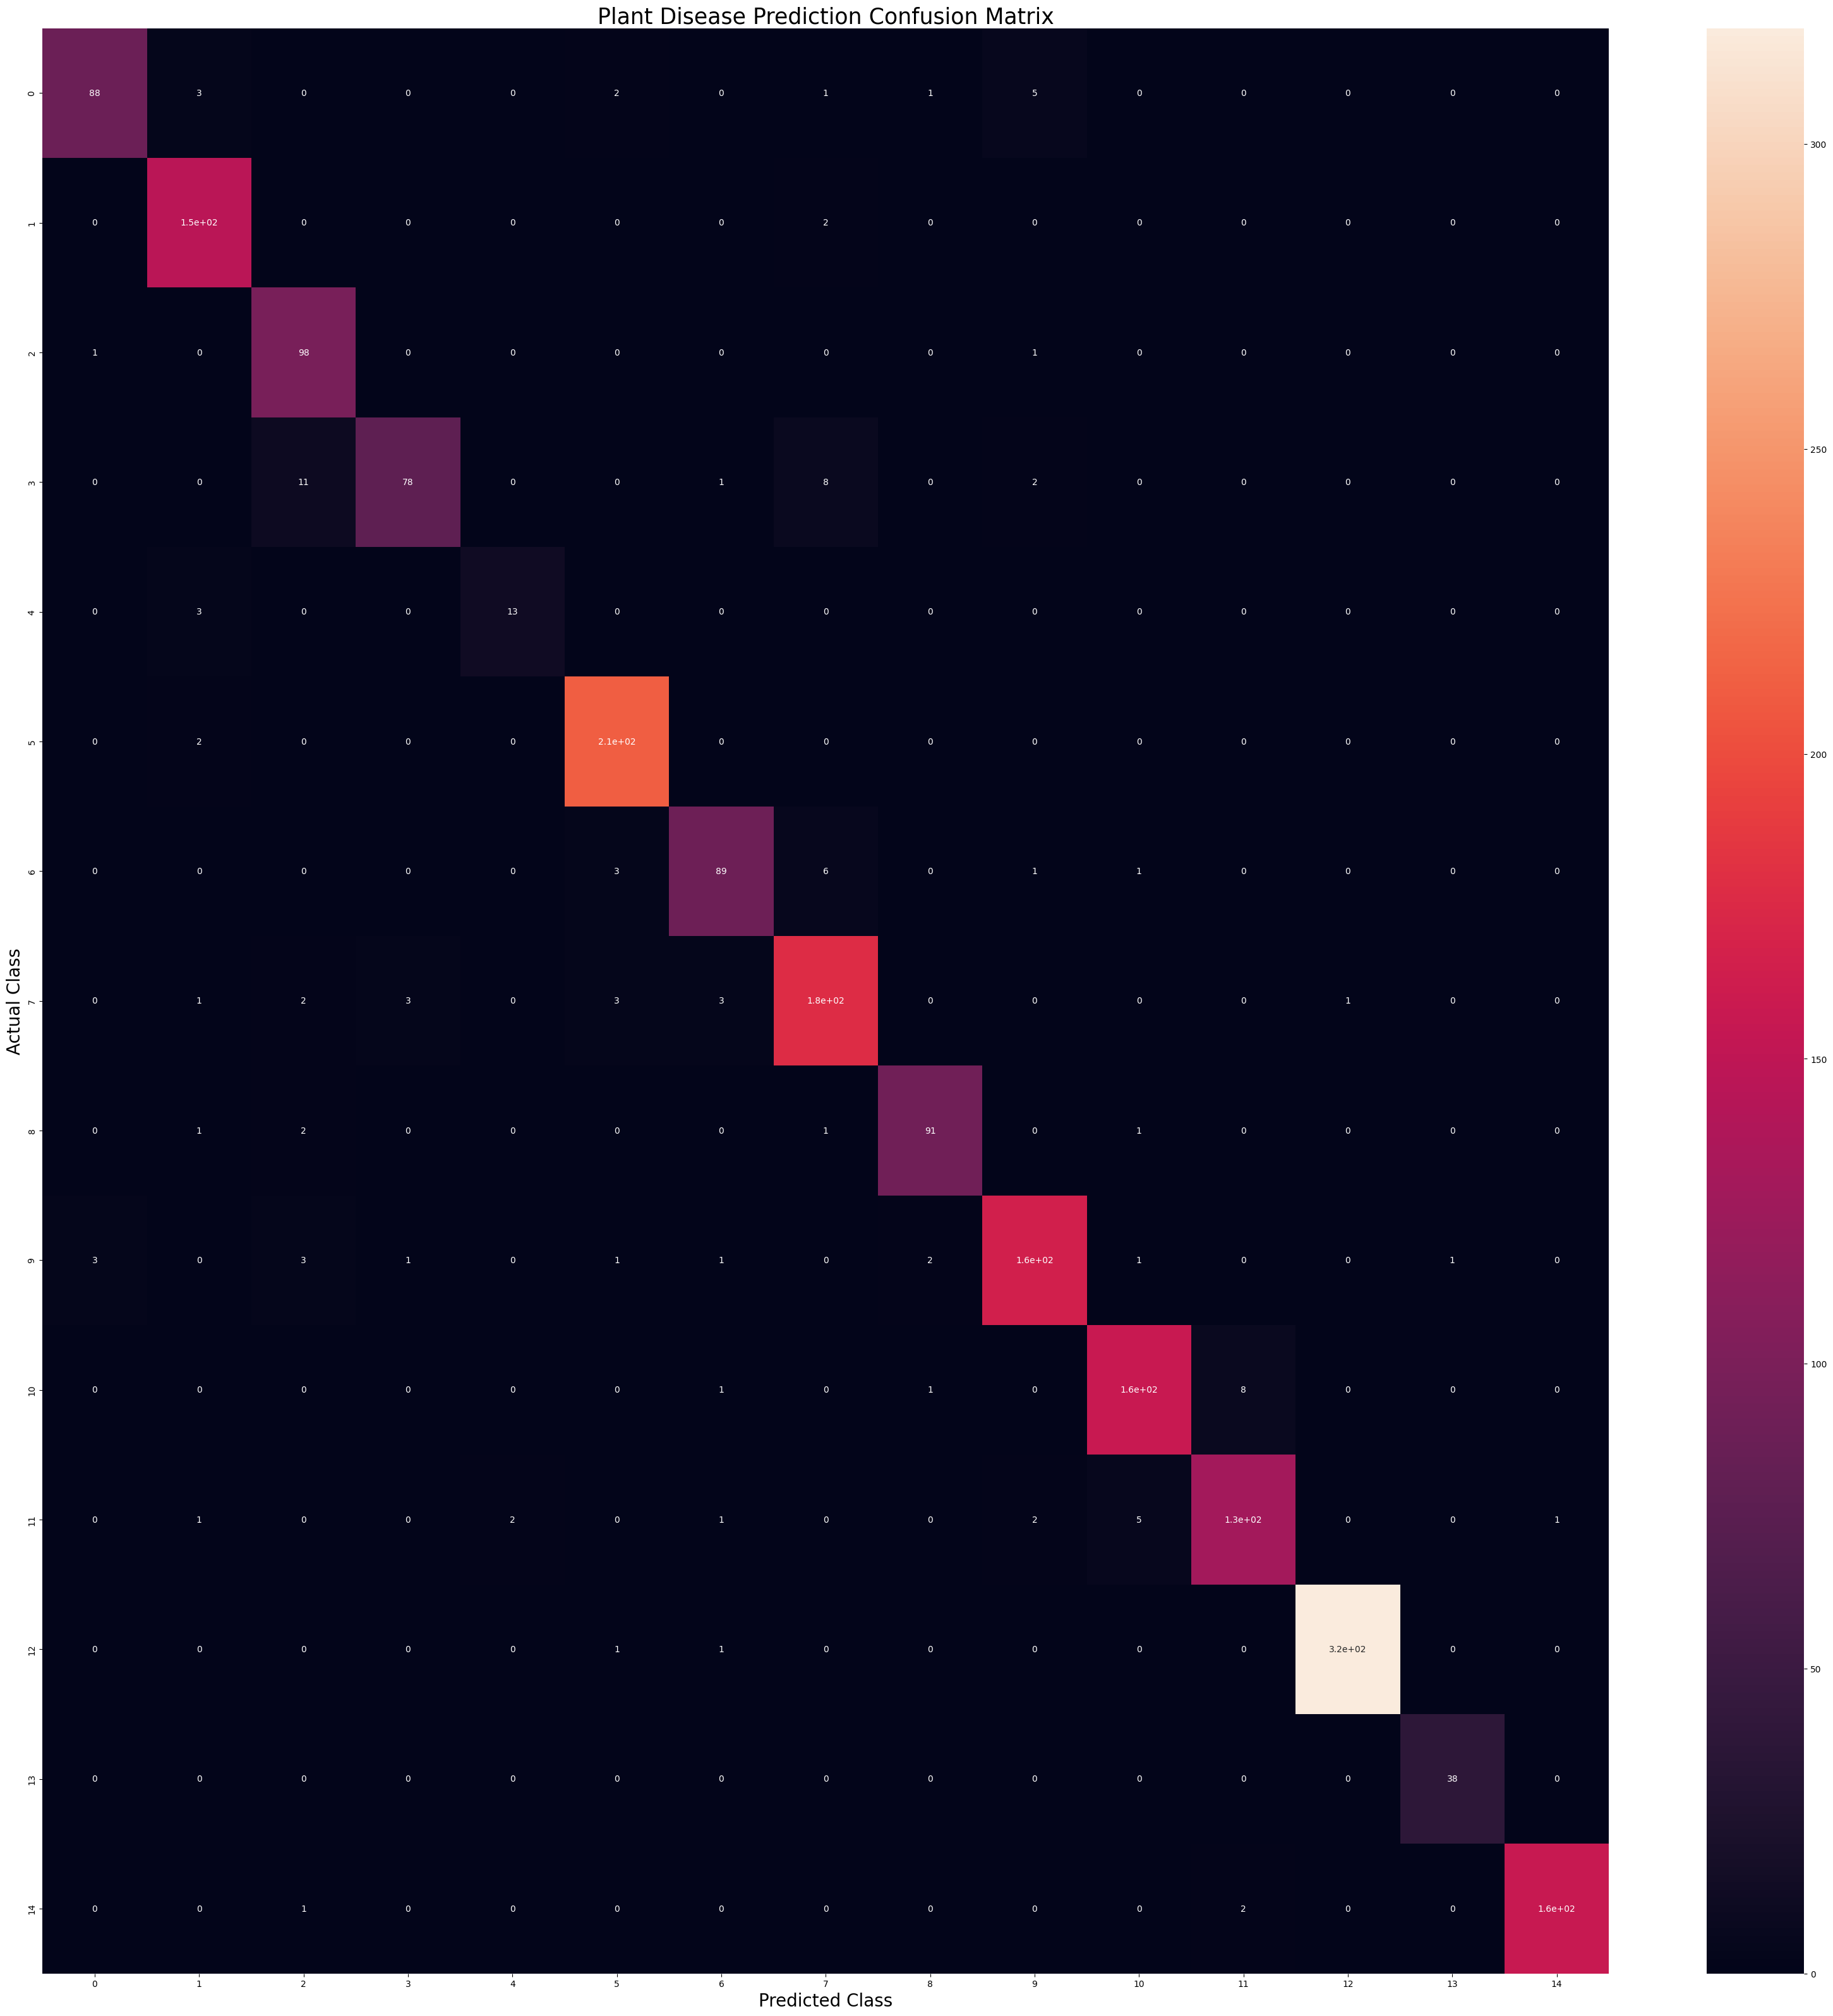

In [117]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()